# Wicklow isolates Pathogenie vs JC pipeline results

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snpgenie import tools, aligners, app, trees

In [2]:
meta = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/sampleInformation_NoAnimalIDs_18-12-19.csv')
meta

,SeqID,Forward,Reverse,NumberMapped,MappingProp,SequencingDate,County,VCF,Coverage,AverageDepth,Aliquot,Species,Date
0,1034,1034_S91_L001-4_R1_001.fastq.gz,1034_S91_L001-4_R2_001.fastq.gz,902962,0.999386,24-09-19,Monaghan,1034_1.vcf.gz,0.900721,27.709380,TB19-001034,NaN,NaN
1,1143,1143_S21_L001-4_R1_001.fastq.gz,1143_S21_L001-4_R2_001.fastq.gz,4083983,0.997583,29-07-19,Monaghan,1143_1.vcf.gz,0.988193,122.031793,TB19-001143,Cow,NaN
2,1147,1147_S91_L001-4_R1_001.fastq.gz,1147_S91_L001-4_R2_001.fastq.gz,2544407,0.998363,29-07-19,Monaghan,1147_2.vcf.gz,0.977731,76.976549,TB19-001147,Cow,NaN
3,1212,1212_S58_L001-4_R1_001.fastq.gz,1212_S58_L001-4_R2_001.fastq.gz,1944433,0.702596,29-07-19,Monaghan,1212_3.vcf.gz,0.969578,52.156617,TB19-001212,Cow,NaN
4,13-11594,13-11594_S85_L001-4_R1_001.fastq.gz,13-11594_S85_L001-4_R2_001.fastq.gz,2988951,0.999445,15-03-19,Wicklow,13-11594_2.vcf.gz,0.984226,88.893592,TB14-011594,Deer,2014-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,59-MBovis,59-MBovis_S33_L001-4_R1_001.fastq.gz,59-MBovis_S33_L001-4_R2_001.fastq.gz,3450574,0.997713,09-07-18,Wicklow,59-MBovis_27.vcf.gz,0.992081,105.080641,TB15-005018,Cow,2015-06-11
214,7-10423,7-10423_S73_L001-4_R1_001.fastq.gz,7-10423_S73_L001-4_R2_001.fastq.gz,3444775,0.999483,15-03-19,Wicklow,7-10423_27.vcf.gz,0.981583,102.215471,TB14-010423,Deer,2014-10-23
215,717,717_S28_L001-4_R1_001.fastq.gz,717_S28_L001-4_R2_001.fastq.gz,5103197,0.998784,29-07-19,Monaghan,717_44.vcf.gz,0.988343,150.909946,TB19-000717,Badger,NaN
216,724p,724p_S44_L001-4_R1_001.fastq.gz,724p_S44_L001-4_R2_001.fastq.gz,3800780,0.998031,29-07-19,Monaghan,724p_45.vcf.gz,0.986323,114.284870,TB19-000724,Badger,NaN


## Run workflow 

In [ ]:
reload(app)
reload(trees)
args = {'threads':10, 'outdir': '/storage/btbgenie/wicklow_results', 'labelsep':'_',
        'input':['/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_07-01-18/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_15-03-19/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_09-07-18/'],       
         'reference': None, 'overwrite':False,
         'trim': True,
         'filters' : 'QUAL>=40 && FORMAT/DP>=30 && DP4>=4 && MQ>30',
         'custom_filters': True, 'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## Compare sites matrix

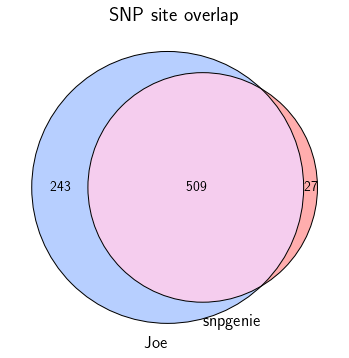

In [6]:
smat = pd.read_csv('/storage/btbgenie/wicklow_results/core.txt',sep=' ',index_col=0)
smat.index
joe_sites = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/FASTA/fastaPositions_Prox-10_18-12-2019.txt')
#print (joe_sites)
plt.figure(figsize=(6,6))
import matplotlib_venn
mpl.rc('text', usetex=True)
mpl.rc('font',size=14)
sets=[set(joe_sites.Position),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Joe','snpgenie'],set_colors=['#4d88ff','#ff3333'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_joe.png',dpi=100)

In [32]:
#frequencies of sites
csqmat = pd.read_csv('../test_results/csq.matrix').set_index(['gene','aa'])
sitefreqs = (csqmat.sum(1)/len(csqmat.columns)).sort_values(ascending=False)
sitefreqs.value_counts()

0.071429    1794
0.214286     881
0.142857     401
0.857143     153
0.785714      77
1.000000      64
0.285714      36
0.500000      21
0.571429      10
0.714286       6
0.642857       3
0.428571       3
0.357143       2
dtype: int64

In [28]:
#print(W.fastq_table)
meta['name'] = meta.Forward.apply(lambda x: x.split('.')[0])
print(meta.loc[0])
s = pd.merge(W.fastq_table,meta,on='name')
labelmap = dict(zip(s['sample'],s.County))
#print (labelmap)


SeqID                                        1034
Forward           1034_S91_L001-4_R1_001.fastq.gz
Reverse           1034_S91_L001-4_R2_001.fastq.gz
NumberMapped                               902962
MappingProp                              0.999386
SequencingDate                           24-09-19
County                                   Monaghan
VCF                                 1034_1.vcf.gz
Coverage                                 0.900721
AverageDepth                              27.7094
Aliquot                               TB19-001034
Species                                       NaN
Date                                          NaN
name                       1034_S91_L001-4_R1_001
Name: 0, dtype: object


In [ ]:
reload(trees)
t,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants', ref='ref',labelmap=labelmap)
t.render("%%inline",tree_style=ts)

## Compare trees

In [ ]:
reload(trees)
t = trees.create_tree('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/mlTree_WICKLOW_18-12-2019.tree')#, labelmap)
t.render("%%inline")

In [ ]:
csqmat = pd.read_csv('')